title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: rating, dtype: int64


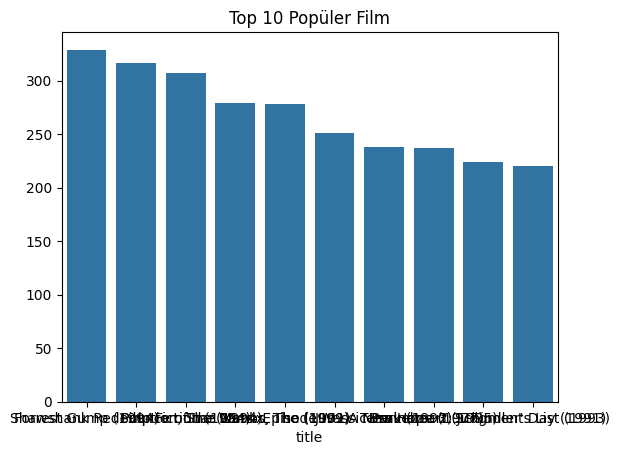

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# CSV dosyalarını oku
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv')
tags = pd.read_csv('data/tags.csv')
links = pd.read_csv('data/links.csv')

# Basit içerik tabanlı öneri için movieId ve genres kullanacağız
# Popülerlik tabanlı öneri için ratings ile birleşim yapacağız
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Örnek: film başına oy sayısı
top_movies = movie_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(10)
print(top_movies)

sns.barplot(x=top_movies.index, y=top_movies.values)
plt.title("Top 10 Popüler Film")
plt.show()


In [46]:
def precision_at_k(recommended, actual, k=5):
    recommended_k = recommended[:k]
    relevant_items = set(actual)
    hits = sum([1 for item in recommended_k if item in relevant_items])
    return hits / k

def recall_at_k(recommended, actual, k=5):
    recommended_k = recommended[:k]
    relevant_items = set(actual)
    hits = sum([1 for item in recommended_k if item in relevant_items])
    return hits / len(relevant_items) if relevant_items else 0

# Örnek kullanım
actual_items = [1, 2, 3]  # kullanıcı gerçekten izlediği filmler
recommended_items = [2, 3, 4, 5, 6]  # önerilen filmler
print("Precision@5:", precision_at_k(recommended_items, actual_items, k=5))
print("Recall@5:", recall_at_k(recommended_items, actual_items, k=5))


# Precision → Öneriler doğru mu? (% bazlı)
# Recall → Doğru öğeleri ne kadar yakaladık? (% bazlı)


Precision@5: 0.4
Recall@5: 0.6666666666666666


In [47]:
def popularity_based_recommender(movie_ratings, top_n=5):
    popular_items = movie_ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(top_n)
    return popular_items.index.tolist()

print(popularity_based_recommender(movie_ratings))


[356, 318, 296, 593, 2571]


In [48]:
# İÇERİK TABANLI ÖNERİ SİSTEMİ

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

movies = pd.read_csv('data/movies.csv') 

# TF-IDF ile film türlerini vektörize et
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Cosine similarity hesapla. İki vektör arasındaki benzerliği ölçer (0–1 arası).
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
# Cosine similarity = iki vektör arasındaki açının kosinüsü.
# Sonuç: NxN bir matris, N = film sayısı.
# cosine_sim[i][j] → i. ve j. film arasındaki benzerlik (0–1 arası).

# Film indexi ile eşleştirme
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

# Öneri fonksiyonu
def content_based_recommender(title, top_n=5):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]  # kendini çıkar
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()

# Örnek kullanım
print("Önerilen Filmler:", content_based_recommender("Toy Story (1995)"))


# TF-IDF: Film türlerini metin olarak vektörize eder.
# Cosine Similarity: Filmler arasındaki benzerliği hesaplar.
# Öneri Fonksiyonu: Verilen bir filme benzer top_n filmi listeler.

Önerilen Filmler: ['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)']


In [49]:
# İşbirlikçi Filtreleme (Collaborative Filtering)

# Kullanıcıların benzerliklerine göre tahmin yapma fikrine dayanır.
# En bilinen yöntem: Matris Faktörizasyonu (SVD)

In [50]:
import pandas as pd
import numpy as np

# ratings ve movies CSV'lerini oku
ratings = pd.read_csv('data/ratings.csv')  # userId, movieId, rating, timestamp
movies = pd.read_csv('data/movies.csv')    # movieId, title, genres

# Film isimlerini ratings ile birleştir
movie_ratings = pd.merge(ratings, movies, on='movieId')

# Kullanıcı-Ürün matrisi oluştur
user_item_matrix = movie_ratings.pivot_table(index='userId', columns='title', values='rating').fillna(0)
#pivot_table → kullanıcıları satırlara, filmleri sütunlara, puanları hücrelere yerleştirir.
#fillna(0) → kullanıcı filmleri izlemediyse 0 koyar.
print(user_item_matrix.shape)


(610, 9719)


In [51]:
from numpy.linalg import svd

# Kullanıcı-Ürün matrisi (NumPy array)
R = user_item_matrix.values

# Ortalama çıkarma (centered)
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

# SVD → Kullanıcı ve film özelliklerini düşük boyutlu vektörlere ayırır.
U, sigma, Vt = np.linalg.svd(R_demeaned, full_matrices=False)

# sigma matrisini diagonal hale getir
sigma = np.diag(sigma)

# Yaklaşık kullanıcı-filme tahmin matrisi
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)
#Tahmin matrisi preds_df → Her kullanıcının her film için tahmini puanı.

In [52]:
#Kullanıcıya film önerme methodu

# ratings ile movies.csv'i birleştir
ratings_with_titles = pd.merge(ratings, movies[['movieId','title']], on='movieId')

def collaborative_recommender(preds_df, user_id, movies_df, original_ratings, top_n=5):
    # Tahminleri sırala
    user_row = preds_df.loc[user_id].sort_values(ascending=False)
    
    # Kullanıcının zaten izlediği filmleri çıkar
    watched_movies = original_ratings[original_ratings.userId == user_id]['title'].tolist()
    recommendations = user_row.drop(labels=watched_movies).head(top_n).index.tolist()
    
    return recommendations

# Örnek kullanım
user_id = 1
recommended_movies = collaborative_recommender(preds_df, user_id, movies, ratings_with_titles, top_n=5)
print(f"Kullanıcı {user_id} için önerilen filmler:", recommended_movies)

#Kullanıcının izlediği filmler çıkarılıyor, böylece yeni filmler öneriliyor.
#top_n=5 → ilk 5 öneriyi alıyoruz.


Kullanıcı 1 için önerilen filmler: ['Terminator 2: Judgment Day (1991)', 'Aliens (1986)', 'Casablanca (1942)', 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)', 'In the Line of Fire (1993)']


In [54]:
# Hibrit Sistem – İçerik + İşbirlikçi
# Basit yöntem: içerik tabanlı önerilerden ve işbirlikçi önerilerden ortak bir skor oluştur.

def hybrid_recommender(user_id, title, top_n=5, alpha=0.5):
    # İçerik tabanlı öneriler
    content_recs = content_based_recommender(title, top_n=top_n*2)
    
    # İşbirlikçi öneriler
    collab_recs = collaborative_recommender(preds_df, user_id, movies, ratings_with_titles, top_n=top_n*2)
    
    # Basit birleştirme: ilk top_n ortak veya sırayla
    combined = list(dict.fromkeys(content_recs + collab_recs))[:top_n]
    return combined

# Örnek kullanım
print(hybrid_recommender(user_id=1, title="Toy Story (1995)", top_n=5))

# alpha parametresiyle ağırlık verebiliriz (daha gelişmiş versiyonda).
# Şu anda basit bir birleştirme yöntemi ile hibrit öneri oluşturduk.


['Antz (1998)', 'Toy Story 2 (1999)', 'Adventures of Rocky and Bullwinkle, The (2000)', "Emperor's New Groove, The (2000)", 'Monsters, Inc. (2001)']


In [55]:
# Özet Mantık

# Kullanıcı-Ürün Matrisi → Kullanıcıların filmleri nasıl puanladığını gösterir.
# SVD → Kullanıcı ve film özelliklerini öğrenir, bilinmeyen puanları tahmin eder.
# İşbirlikçi öneri → Kullanıcının ilgi duyacağı filmleri tahminler üzerinden seçer.
# Hibrit öneri → İçerik ve işbirlikçi önerileri birleştirir, daha iyi sonuç verir.

In [1]:
# Hedef:
# Modelimizin performansını ölçmek için başarı metriklerini (Precision@K, Recall@K, NDCG) uygulamak.
# Bunu yaparken:
# Eğitim/validasyon splitini kullanacağız.
# Kullanıcı bazlı öneriler üreteceğiz.
# Her kullanıcı için tahmin edilen öneriler ile gerçek etkileşimleri kıyaslayacağız.

In [4]:
import pandas as pd

# Örnek: kullanıcıların verdiği puanlar
ratings = pd.read_csv("data/ratings.csv")  # userId, movieId, rating
movies = pd.read_csv("data/movies.csv")    # movieId, title, genres

# Pozitif etkileşim: rating >= 4 olanlar
user_positive = ratings[ratings["rating"] >= 4]


In [ ]:
# movieId -> index map
movieId_to_idx = pd.Series(movies.index, index=movies["movieId"]).to_dict()
idx_to_movieId = pd.Series(movies["movieId"], index=movies.index).to_dict()

In [ ]:
def recommend(movie_id, model, k=10):
    """movieId alır, cosine similarity matrisinden benzer filmleri döndürür"""
    if movie_id not in movieId_to_idx:  #movie_id: Kullanıcının izlediği film (referans film).
        return []  # eğer film yoksa boş öneri
    idx = movieId_to_idx[movie_id]  # movieId → index
    scores = list(enumerate(model[idx]))  #enumerate(model[movie_id]) → Tüm diğer filmler ile benzerlik skorlarını alır.
    scores = sorted(scores, key=lambda x: x[1], reverse=True) #Benzerlik skoruna göre büyükten küçüğe sırala.
    rec_indices = [i[0] for i in scores[1:k+1]] #Kendisi hariç top K öneri al.
    return [idx_to_movieId[i] for i in rec_indices]  # index → movieId

# model → Cosine similarity matrisi veya benzerlik matrisi.
# Çıktı: Önerilen film indeksleri listesi.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

movies = pd.read_csv("data/movies.csv")

# Türleri TF-IDF ile sayısallaştır
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Cosine similarity matrisi
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [ ]:
# Precision@K ve Recall@K
# Her kullanıcı için hesapla → ortalama al.
def precision_recall_at_k(user_id, k=10):
    # Kullanıcının beğendiği filmler
    true_items = set(user_positive[user_positive["userId"] == user_id]["movieId"])  #true_items:Kullanıcının gerçekten sevdiği filmler (ground truth).
    if not true_items:
        return None, None
    
    # İlk beğendiği filmden öneriler al
    first_movie = list(true_items)[0]
    recs = recommend(first_movie, cosine_sim, k) #Modelin önerdiği filmler.
    if not recs:
        return None, None
    
    hits = len(set(recs) & true_items)
    precision = hits / k
    recall = hits / len(true_items)
    return precision, recall

# Precision: Önerilen filmlerin kaç tanesi doğru (hits/k).
# Recall: Kullanıcının sevdiği filmlerin kaçını yakaladık (hits/len(true_items)).

In [16]:
precisions, recalls = [], []
for user in ratings["userId"].unique():
    p, r = precision_recall_at_k(user, k=10)
    if p is not None:
        precisions.append(p)
        recalls.append(r)

print("Precision@10:", sum(precisions)/len(precisions))
print("Recall@10:", sum(recalls)/len(recalls))

# Her kullanıcı için Precision ve Recall hesaplanıyor.
# Ortalama alınarak modelin genel başarısı ölçülüyor.

Precision@10: 0.07339901477832513
Recall@10: 0.02180053918535216


In [ ]:
#NDCG, önerilen listenin sıralamasını dikkate alır.
import numpy as np

def ndcg_at_k(user_id, k=10):
    true_items = set(user_positive[user_positive["userId"] == user_id]["movieId"])
    if not true_items:
        return None
    
    first_movie = list(true_items)[0]
    recs = recommend(first_movie, cosine_sim, k)

    gains = [1 if item in true_items else 0 for item in recs]  #gains:Önerilen filmlerin ground truth ile eşleşip eşleşmediğini 1 veya 0 ile gösterir.
    dcg = sum([g / np.log2(i+2) for i, g in enumerate(gains)]) #dcg: Discounted Cumulative Gain: Önerilerin sıralamasına göre değer verir.

    ideal_gains = sorted(gains, reverse=True)
    idcg = sum([g / np.log2(i+2) for i, g in enumerate(ideal_gains)]) #idcg:Ideal DCG: En iyi sıralamada olsaydı maksimum değer.
    
    return dcg / idcg if idcg > 0 else 0

ndcgs = []
for user in ratings["userId"].unique():
    n = ndcg_at_k(user, k=10)
    if n is not None:
        ndcgs.append(n)

print("NDCG@10:", sum(ndcgs)/len(ndcgs))

# NDCG → dcg / idcg → Sıralama doğruluğunu ölçer (0–1 arası).

NDCG@10: 0.28571472959675925
